In [1]:
pip install evaluate seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.3 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=823ec9bc0e620941921e8e8d1c7e80fd0e2f070821aa6243f3e357e8589c8fc5
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval
Note: you may need to restart the kernel to use updated packages.


In [2]:
!python -m spacy download pl_core_news_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 MB 24.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pl_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
import json
from datasets import load_dataset
import spacy
from transformers import AutoTokenizer
from transformers import AutoModelForTokenClassification
import evaluate
import numpy as np
from transformers import TrainingArguments, Trainer

dataset = load_dataset('allegro/klej-nkjp-ner')
print(dataset)

train.csv:   0%|          | 0.00/1.59M [00:00<?, ?B/s]

valid.csv:   0%|          | 0.00/194k [00:00<?, ?B/s]

test.csv:   0%|          | 0.00/219k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/15794 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1941 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2058 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'target'],
        num_rows: 15794
    })
    validation: Dataset({
        features: ['sentence', 'target'],
        num_rows: 1941
    })
    test: Dataset({
        features: ['sentence', 'target'],
        num_rows: 2058
    })
})


In [4]:
nlp = spacy.load('pl_core_news_md')

def assign_bio_tags_with_spacy(example):
    doc = nlp(example["sentence"])  # Przetwarzamy zdanie przez spaCy
    
    tokens = [token.text for token in doc]  # Tokenizacja spaCy
    labels = ["O"] * len(tokens)  # Domyślnie wszystkie tokeny dostają "O"

    for ent in doc.ents:
        entity_type = ent.label_  # Etykieta encji np. PER, LOC, ORG

        for i, token in enumerate(tokens):
            if token in ent.text.split():  # Jeśli token należy do encji
                if labels[i] == "O":  # Sprawdzamy, czy jeszcze nie przypisaliśmy etykiety
                    labels[i] = f"B-{entity_type}"  # Pierwszy token dostaje "B-XXX"
                else:
                    labels[i] = f"I-{entity_type}"  # Kolejne tokeny dostają "I-XXX"

    return {"tokens": tokens, "ner_tags": labels}

In [5]:
dataset = dataset.map(assign_bio_tags_with_spacy)

Map:   0%|          | 0/15794 [00:00<?, ? examples/s]

Map:   0%|          | 0/1941 [00:00<?, ? examples/s]

Map:   0%|          | 0/2058 [00:00<?, ? examples/s]

In [6]:
MODEL_NAME = 'dkleczek/bert-base-polish-cased-v1'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

label_list = list(set(tag for tags in dataset["train"]["ner_tags"] for tag in tags))
label_list.sort()

label2id = {label: i for i, label in enumerate(label_list)}
id2label = {i: label for label, i in label2id.items()}

def tokenize_and_align_labels(sentences):
    tokenized_inputs = tokenizer(
        sentences["tokens"],
        truncation=True,
        is_split_into_words=True,
        padding='max_length',
        max_length=128
    )

    labels = []
    for i, label in enumerate(sentences["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []

        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)  # Ignorujemy subtokens
            elif word_idx != previous_word_idx:
                label_ids.append(label2id[label[word_idx]])  # Pierwszy token słowa dostaje etykietę
            else:
                label_ids.append(label2id[label[word_idx]])  # Pozostałe subtokens dostają tę samą etykietę
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

tokenized_datasets = dataset.map(tokenize_and_align_labels, batched=True)

tokenizer_config.json:   0%|          | 0.00/30.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/489k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/15794 [00:00<?, ? examples/s]

Map:   0%|          | 0/1941 [00:00<?, ? examples/s]

Map:   0%|          | 0/2058 [00:00<?, ? examples/s]

In [7]:
model = AutoModelForTokenClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id
)

pytorch_model.bin:   0%|          | 0.00/531M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at dkleczek/bert-base-polish-cased-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
seqeval = evaluate.load('seqeval')

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_labels = [[label_list[l] for l in label if l != -100] for label in labels]
    true_predictions = [[label_list[p] for p, l in zip(pred, label) if l != -100] for pred, label in zip(predictions, labels)]
    
    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [9]:
training_args = TrainingArguments(
    output_dir='/kaggle/working/ner_polish_model',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    push_to_hub=False,
    logging_dir="/kaggle/working/logs",
    report_to='none'
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-9-2c453e4f1dee>:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [10]:
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.078000,0.077066,0.862859,0.820477,0.841135,0.980009
2,0.040600,0.079511,0.845242,0.863369,0.854209,0.981748
3,0.016800,0.086927,0.854675,0.872708,0.863597,0.982810


TrainOutput(global_step=5925, training_loss=0.05428941750828224, metrics={'train_runtime': 771.5815, 'train_samples_per_second': 61.409, 'train_steps_per_second': 7.679, 'total_flos': 3095498549647872.0, 'train_loss': 0.05428941750828224, 'epoch': 3.0})

In [11]:
output_dir = "/kaggle/working/ner_polish_model"

trainer.save_model(output_dir)  # Zapisuje model, tokenizator i konfigurację
tokenizer.save_pretrained(output_dir)  # Zapisuje tokenizator

('/kaggle/working/ner_polish_model/tokenizer_config.json',
 '/kaggle/working/ner_polish_model/special_tokens_map.json',
 '/kaggle/working/ner_polish_model/vocab.txt',
 '/kaggle/working/ner_polish_model/added_tokens.json',
 '/kaggle/working/ner_polish_model/tokenizer.json')

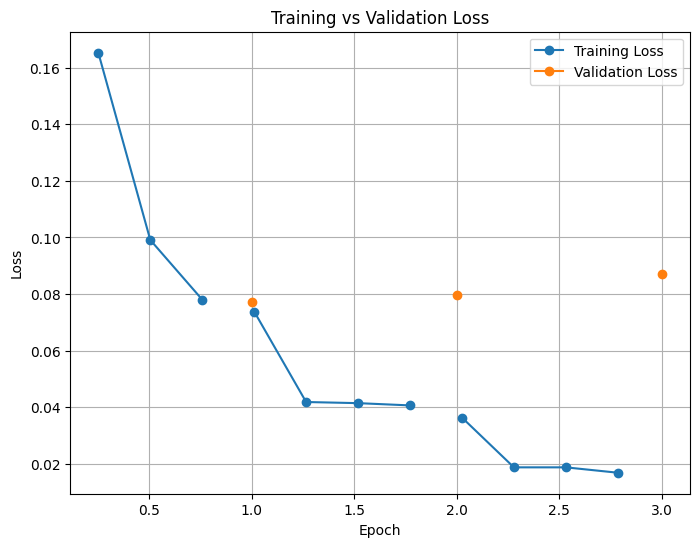

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract loss values from trainer log history
history = trainer.state.log_history

# Convert to DataFrame
df = pd.DataFrame(history)

# Filter only relevant columns
df = df[["epoch", "loss", "eval_loss"]]

# Plot loss curves
plt.figure(figsize=(8, 6))
plt.plot(df["epoch"], df["loss"], label="Training Loss", marker="o")
plt.plot(df["epoch"], df["eval_loss"], label="Validation Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


In [13]:
trainer.state.log_history

[{'loss': 0.1653,
  'grad_norm': 4.8759613037109375,
  'learning_rate': 1.8312236286919833e-05,
  'epoch': 0.25316455696202533,
  'step': 500},
 {'loss': 0.0991,
  'grad_norm': 5.5610737800598145,
  'learning_rate': 1.662447257383966e-05,
  'epoch': 0.5063291139240507,
  'step': 1000},
 {'loss': 0.078,
  'grad_norm': 4.016184329986572,
  'learning_rate': 1.4936708860759495e-05,
  'epoch': 0.759493670886076,
  'step': 1500},
 {'eval_loss': 0.07706630975008011,
  'eval_precision': 0.8628592215351036,
  'eval_recall': 0.8204773434797648,
  'eval_f1': 0.8411347517730496,
  'eval_accuracy': 0.9800088456435205,
  'eval_runtime': 8.8108,
  'eval_samples_per_second': 220.298,
  'eval_steps_per_second': 27.58,
  'epoch': 1.0,
  'step': 1975},
 {'loss': 0.0738,
  'grad_norm': 4.16926383972168,
  'learning_rate': 1.3248945147679326e-05,
  'epoch': 1.0126582278481013,
  'step': 2000},
 {'loss': 0.0418,
  'grad_norm': 2.1637983322143555,
  'learning_rate': 1.1561181434599158e-05,
  'epoch': 1.26582